## This notebook is an extension of the simple_classifier.ipynb. The only thing which is added is the inclusion of class_weights parameter to model.fit() . A nice trick was found and the parameter increased the performance significantly.

In [ ]:
#https://keras.io/examples/vision/image_classification_from_scratch/
#accessed May 2020

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pathlib
import pandas as pd
import numpy as np
from keras_preprocessing.image import ImageDataGenerator


In [3]:
#NOTE - I am working in an nvidia-docker image with official tensorflow docker.
# I had to add this line AND 'trust' the notebook on top-right. Otherwise an ugly
# cudNN error is present.

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
def csvSplitter(dataframe, split_ratio):
    """
    To use the data generator in keras with flow_from_dataset, you need a helper function to perform the train/test
    split.
    
    Input: a pandas CSV/Table of all your data.
    Output : the same dataframe, split into seperate training/validation dataframes, to be used in rest of pipeline
    """
    dataframe = dataframe.sample(frac=1).reset_index(drop=True) #Shuffles DataFrame
    validation_index = round(dataframe.shape[0] * split_ratio) # Gets # of rows/points in validation set 
    training_index = dataframe.shape[0] - validation_index # Gets # of rows/points in training set
    train_valid_split = np.concatenate((np.ones(validation_index),np.zeros(training_index))) # creates train-valid column
    dataframe['trainValid'] = train_valid_split # adds the splitting ID to the dataframe
    train_df = dataframe[dataframe['trainValid'] == 0.0]
    valid_df = dataframe[dataframe['trainValid'] == 1.0]
    return train_df, valid_df

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    #x = data_augmentation(inputs)

    # Entry block
    #x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(inpu)
        # This is done already because we used an ImageDataGenerator
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

In [10]:
data_dir = pathlib.Path('/tf/beetleData/images/')
labels = pd.read_csv('/tf/beetleData/labels/master_rbi.csv')
labels.columns

Index(['Family:', 'Subfamily:', 'Country:', 'Province:', 'Genus:', 'Species:',
       'View:', 'Filename:'],
      dtype='object')

In [16]:
def get_beetle_labels(y_target = 'Family:',
                      data_dir = '/tf/beetleData/images/',
                      label_file = '/tf/beetleData/labels/master_rbi.csv',
                      top_classes = 6):
    """
    Read label file
    Get images from Dorsal View
    Take those images and use csvsplitter to return train and test dataframes
    """
    labels = pd.read_csv(label_file)
    assert y_target in labels.columns, "y_target should be a column in the label_file!"
    
    data_dir = pathlib.Path('/tf/beetleData/images/')
    dorsal_data = labels[labels["View:"] == "Dorsal"] #filter images that are from dorsal view
    dorsal_data[y_target].value_counts().sort_values().plot(kind = 'barh') # preview the distribution
    top6 = dorsal_data[y_target].value_counts(normalize=True)[:top_classes]
    top6 = top6.index.values # get top 6 most common classes.
    top6_df = dorsal_data[dorsal_data[y_target].isin(top6)] #filter images from only top 6 classes
    top6_train, top6_valid = csvSplitter(top6_df, .2)
    
    return top6_train, top6_valid


In [13]:
image_size = (75,54) # PARAMETER

datagen=ImageDataGenerator(rescale=1./255)
train_generator=datagen.flow_from_dataframe(dataframe=top6_train,
                                            directory="/tf/beetlevision/images",
                                            x_col="Filename:", y_col="Family:",
                                            class_mode="categorical",
                                            target_size=image_size,
                                            batch_size=1)
validation_generator=datagen.flow_from_dataframe(dataframe=top6_valid,
                                            directory="/tf/beetlevision/images",
                                            x_col="Filename:", y_col="Family:",
                                            class_mode="categorical",
                                            target_size=image_size,
                                            batch_size=12)

model = make_model(input_shape=image_size + (3,), num_classes=6)
epochs = 1

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
history58x58 = model.fit(
    train_generator,validation_data=validation_generator,epochs=epochs
    #    train_generator,validation_data=validation_generator,epochs=epochs, callbacks=callbacks
)

Found 2343 validated image filenames belonging to 6 classes.
Found 586 validated image filenames belonging to 6 classes.
2343/2343 [==============================] - 19s 8ms/step - loss: 1.2367 - accuracy: 0.6073 - val_loss: 0.8418 - val_accuracy: 0.7491


In [ ]:
model = make_model(input_shape=image_size + (3,), num_classes=6)
epochs = 1

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
history58x58 = model.fit(
    train_generator,validation_data=validation_generator,epochs=epochs
    #    train_generator,validation_data=validation_generator,epochs=epochs, callbacks=callbacks
)

ImageDataGenerator.flow_from_dataframe(
    dataframe,
    directory=None,
    x_col="filename",
    y_col="class",
    weight_col=None,
    target_size=(256, 256),
    color_mode="rgb",
    classes=None,
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=None,
    save_to_dir=None,
    save_prefix="",
    save_format="png",
    subset=None,
    interpolation="nearest",
    validate_filenames=True,
    **kwargs
)


In [ ]:
train_generator.class_indices

In [15]:
y_train = train_generator.classes

In [ ]:
!pip install sklearn
from sklearn.utils import class_weight

In [ ]:
np.unique(y_train)

In [17]:
#cool trick to automatically generate the relative weights to make the classes appear balanced.
    #https://datascience.stackexchange.com/questions/13490/how-to-set-class-weights-for-imbalanced-classes-in-keras
from sklearn.utils import class_weight
y_train = train_generator.classes
c_weights = class_weight.compute_class_weight('balanced',
                                             np.unique(y_train),
                                             np.array(y_train))
class_weight_dict = dict(enumerate(c_weights))

NameError: name 'train_generator' is not defined

In [17]:
c_weights

array([2.39570552, 3.33760684, 0.68031359, 5.20666667, 1.63389121,
       0.33234043])

In [85]:
#without class_weights

model = make_model(input_shape=image_size + (3,), num_classes=6)
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
history_basic = model.fit(
    train_generator,validation_data=validation_generator,epochs=epochs
    #    train_generator,validation_data=validation_generator,epochs=epochs, callbacks=callbacks
)

Epoch 1/25
98/98 [==============================] - 12s 121ms/step - loss: 0.5764 - accuracy: 0.8032 - val_loss: 1.8503 - val_accuracy: 0.0734
Epoch 2/25
98/98 [==============================] - 12s 119ms/step - loss: 0.2624 - accuracy: 0.9206 - val_loss: 2.6529 - val_accuracy: 0.0734
Epoch 3/25
98/98 [==============================] - 12s 118ms/step - loss: 0.1676 - accuracy: 0.9454 - val_loss: 3.9460 - val_accuracy: 0.0734
Epoch 4/25
98/98 [==============================] - 12s 120ms/step - loss: 0.1219 - accuracy: 0.9586 - val_loss: 6.9521 - val_accuracy: 0.0734
Epoch 5/25
98/98 [==============================] - 12s 120ms/step - loss: 0.1009 - accuracy: 0.9637 - val_loss: 2.7816 - val_accuracy: 0.4949
Epoch 6/25
98/98 [==============================] - 12s 119ms/step - loss: 0.0999 - accuracy: 0.9659 - val_loss: 2.2255 - val_accuracy: 0.3771
Epoch 7/25
98/98 [==============================] - 12s 120ms/step - loss: 0.0637 - accuracy: 0.9795 - val_loss: 0.4838 - val_accuracy: 0.8976

In [23]:
#with class_weights

model = make_model(input_shape=image_size + (3,), num_classes=6)
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
history_plus_weights = model.fit(
    train_generator,validation_data=validation_generator,epochs=epochs, class_weight=class_weight_dict
    #    train_generator,validation_data=validation_generator,epochs=epochs, callbacks=callbacks
)

Epoch 1/25
2343/2343 [==============================] - 19s 8ms/step - loss: 2.0190 - accuracy: 0.2027 - val_loss: 1.9592 - val_accuracy: 0.1775
Epoch 2/25
2343/2343 [==============================] - 19s 8ms/step - loss: 1.6919 - accuracy: 0.2868 - val_loss: 2.6603 - val_accuracy: 0.0256
Epoch 3/25
2343/2343 [==============================] - 19s 8ms/step - loss: 1.5555 - accuracy: 0.3461 - val_loss: 1.7397 - val_accuracy: 0.4215
Epoch 4/25
2343/2343 [==============================] - 19s 8ms/step - loss: 1.4276 - accuracy: 0.4255 - val_loss: 1.5650 - val_accuracy: 0.4198
Epoch 5/25
2343/2343 [==============================] - 20s 8ms/step - loss: 1.1492 - accuracy: 0.5570 - val_loss: 1.9097 - val_accuracy: 0.2543
Epoch 6/25
2343/2343 [==============================] - 20s 8ms/step - loss: 0.9115 - accuracy: 0.6773 - val_loss: 1.2038 - val_accuracy: 0.6348
Epoch 7/25
2343/2343 [==============================] - 22s 10ms/step - loss: 0.6688 - accuracy: 0.7802 - val_loss: 1.4516 - val_a

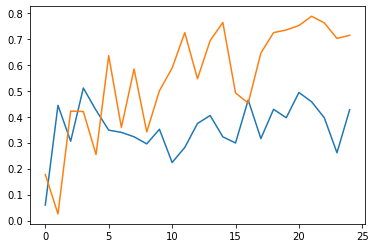

In [26]:
import matplotlib.pyplot as plt
pd.DataFrame(history_basic.history)['val_accuracy'].plot() # blue 
pd.DataFrame(history_plus_weights.history)['val_accuracy'].plot() # yellow

In [ ]:
# img = keras.preprocessing.image.load_img(
#     "/tf/beetlevision/images/rbi_100.jpg", target_size=image_size
# )
# img_array = keras.preprocessing.image.img_to_array(img)
# img_array = tf.expand_dims(img_array, 0)  # Create batch axis

# predictions = model.predict(img_array)
# predictions


In [31]:
train_generator

In [68]:
#with class_weights



image_size = (58,58)
datagen=ImageDataGenerator(rescale=1./255)
train_generator=datagen.flow_from_dataframe(dataframe=top6_train,
                                            directory="/tf/beetlevision/images",
                                            x_col="Filename:", y_col="Family:",
                                            class_mode="categorical",
                                            target_size=image_size,
                                            batch_size=24)
validation_generator=datagen.flow_from_dataframe(dataframe=top6_valid,
                                            directory="/tf/beetlevision/images",
                                            x_col="Filename:", y_col="Family:",
                                            class_mode="categorical",
                                            target_size=image_size,
                                            batch_size=24)


model = make_model(input_shape=image_size + (3,), num_classes=6)
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

Found 2343 validated image filenames belonging to 6 classes.
Found 586 validated image filenames belonging to 6 classes.


In [73]:
type(train_generator)

keras_preprocessing.image.dataframe_iterator.DataFrameIterator

In [18]:
history_plus_weights = model.fit(
    train_generator, y = smoothed_labels,validation_data=validation_generator,epochs=epochs, class_weight=class_weight_dict
    #    train_generator,validation_data=validation_generator,epochs=epochs, callbacks=callbacks
)

NameError: name 'model' is not defined

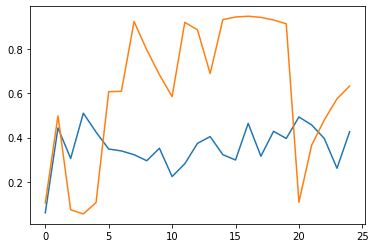

In [80]:
pd.DataFrame(history_basic.history)['val_accuracy'].plot() # blue 
pd.DataFrame(history_plus_weights.history)['val_accuracy'].plot() # yellow

In [64]:
# FROM: https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python/
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
# define example

def ohe(data):
    """
    one-hot-encoding"""
    values = array(data)
    print(values)
    # integer encode
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)
    print(integer_encoded)
    # binary encode
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    print(onehot_encoded)
    # invert first example
    inverted = label_encoder.inverse_transform([argmax(onehot_encoded[0, :])])
    return onehot_encoded

In [70]:
smoothed_labels = smooth_labels(ohe(train_generator.classes))
smoothed_labels.shape

[5 5 2 ... 5 4 0]
[5 5 2 ... 5 4 0]
[[0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0.]]


(2343, 6)

In [66]:
# Looks like the keras object which I used to load in the data is not compatible with one-hot-encoding.
    #it may require loading in the data another way.

In [56]:
# FROM : https://www.pyimagesearch.com/2019/12/30/label-smoothing-with-keras-tensorflow-and-deep-learning/
def smooth_labels(labels, factor=0.1):
	# smooth the labels
	labels *= (1 - factor)
	labels += (factor / labels.shape[1])
	# returned the smoothed labels
	return labels

In [61]:
smooth_labels(onehot_encoded)

array([[0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.01666667,
        0.91666667],
       [0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.01666667,
        0.91666667],
       [0.01666667, 0.01666667, 0.91666667, 0.01666667, 0.01666667,
        0.01666667],
       ...,
       [0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.01666667,
        0.91666667],
       [0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.91666667,
        0.01666667],
       [0.91666667, 0.01666667, 0.01666667, 0.01666667, 0.01666667,
        0.01666667]])

In [37]:
train_generator.class_indices

{'Buprestidae': 0,
 'Carabidae': 1,
 'Cerambycidae': 2,
 'Cicindelidae': 3,
 'Lucanidae': 4,
 'Scarabaeidae': 5}

In [40]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit([1, 2, 2, 6])

le.classes_

le.transform([1, 1, 2, 6])

le.inverse_transform([0, 0, 1, 2])

array([1, 1, 2, 6])

In [43]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(y_train)

le.classes_
le.transform(y_train)
le.inverse_transform([0, 0, 1, 2])

array([0, 0, 1, 2])

In [75]:
loss = keras.losses.CategoricalCrossentropy(label_smoothing=.1)

In [81]:
#with label_smoothing



image_size = (58,58)
datagen=ImageDataGenerator(rescale=1./255)
train_generator=datagen.flow_from_dataframe(dataframe=top6_train,
                                            directory="/tf/beetlevision/images",
                                            x_col="Filename:", y_col="Family:",
                                            class_mode="categorical",
                                            target_size=image_size,
                                            batch_size=24)
validation_generator=datagen.flow_from_dataframe(dataframe=top6_valid,
                                            directory="/tf/beetlevision/images",
                                            x_col="Filename:", y_col="Family:",
                                            class_mode="categorical",
                                            target_size=image_size,
                                            batch_size=24)


model = make_model(input_shape=image_size + (3,), num_classes=6)
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
loss = keras.losses.CategoricalCrossentropy(label_smoothing=.1)
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss=loss,
    metrics=["accuracy"],
)

history_plus_smooth = model.fit(
    #train_generator,validation_data=validation_generator,epochs=epochs, class_weight=class_weight_dict
        train_generator,validation_data=validation_generator,epochs=epochs, callbacks=callbacks
)

Found 2343 validated image filenames belonging to 6 classes.
Found 586 validated image filenames belonging to 6 classes.
Epoch 1/25
98/98 [==============================] - 12s 127ms/step - loss: 0.9069 - accuracy: 0.7926 - val_loss: 1.7408 - val_accuracy: 0.5000
Epoch 2/25
98/98 [==============================] - 12s 121ms/step - loss: 0.6715 - accuracy: 0.9087 - val_loss: 2.0584 - val_accuracy: 0.0734
Epoch 3/25
98/98 [==============================] - 12s 124ms/step - loss: 0.6045 - accuracy: 0.9449 - val_loss: 2.4506 - val_accuracy: 0.0734
Epoch 4/25
98/98 [==============================] - 12s 122ms/step - loss: 0.5402 - accuracy: 0.9761 - val_loss: 2.4990 - val_accuracy: 0.0734
Epoch 5/25
98/98 [==============================] - 12s 124ms/step - loss: 0.5003 - accuracy: 0.9936 - val_loss: 2.2288 - val_accuracy: 0.0802
Epoch 6/25
98/98 [==============================] - 12s 122ms/step - loss: 0.4827 - accuracy: 0.9970 - val_loss: 1.3050 - val_accuracy: 0.5478
Epoch 7/25
98/98 [===

In [82]:
#with class_weights AND smoothing



image_size = (58,58)
datagen=ImageDataGenerator(rescale=1./255)
train_generator=datagen.flow_from_dataframe(dataframe=top6_train,
                                            directory="/tf/beetlevision/images",
                                            x_col="Filename:", y_col="Family:",
                                            class_mode="categorical",
                                            target_size=image_size,
                                            batch_size=24)
validation_generator=datagen.flow_from_dataframe(dataframe=top6_valid,
                                            directory="/tf/beetlevision/images",
                                            x_col="Filename:", y_col="Family:",
                                            class_mode="categorical",
                                            target_size=image_size,
                                            batch_size=24)


model = make_model(input_shape=image_size + (3,), num_classes=6)
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
loss = keras.losses.CategoricalCrossentropy(label_smoothing=.1)
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss=loss,
    metrics=["accuracy"],
)

history_plus_both = model.fit(
    train_generator,validation_data=validation_generator,epochs=epochs, class_weight=class_weight_dict
        #train_generator,validation_data=validation_generator,epochs=epochs, callbacks=callbacks
)

Found 2343 validated image filenames belonging to 6 classes.
Found 586 validated image filenames belonging to 6 classes.
Epoch 1/25
98/98 [==============================] - 12s 123ms/step - loss: 1.2269 - accuracy: 0.6381 - val_loss: 1.7453 - val_accuracy: 0.1041
Epoch 2/25
98/98 [==============================] - 12s 119ms/step - loss: 0.8338 - accuracy: 0.8357 - val_loss: 2.0335 - val_accuracy: 0.0734
Epoch 3/25
98/98 [==============================] - 12s 125ms/step - loss: 0.6724 - accuracy: 0.9061 - val_loss: 2.4084 - val_accuracy: 0.0734
Epoch 4/25
98/98 [==============================] - 12s 123ms/step - loss: 0.5781 - accuracy: 0.9518 - val_loss: 2.3416 - val_accuracy: 0.0768
Epoch 5/25
98/98 [==============================] - 12s 121ms/step - loss: 0.5210 - accuracy: 0.9821 - val_loss: 2.1869 - val_accuracy: 0.1024
Epoch 6/25
98/98 [==============================] - 12s 122ms/step - loss: 0.4942 - accuracy: 0.9898 - val_loss: 1.6490 - val_accuracy: 0.5222
Epoch 7/25
98/98 [===

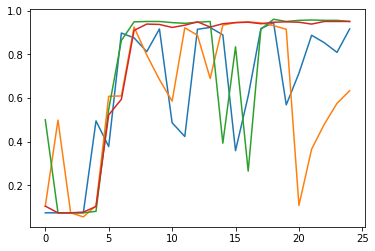

In [91]:
pd.DataFrame(history_basic.history)['val_accuracy'].plot() # blue - basic

pd.DataFrame(history_plus_weights.history)['val_accuracy'].plot() # orange +class_weights

pd.DataFrame(history_plus_smooth.history)['val_accuracy'].plot() # green - +label_smoothing

pd.DataFrame(history_plus_both.history)['val_accuracy'].plot() # red - BOTH

In [92]:
model.save(history_plus_both)

TypeError: expected str, bytes or os.PathLike object, not History